# CytoData 2018 - Hackathon
## Creating a submission entry 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import cytodata

# 1. Load datasets
**Datasets available**: BBBC022 and BBBC036

**Data partitions**: Train and Test

**Features**: CellProfiler and DeepLearning

In [3]:
FEATURES = "CellProfiler"
# FEATURES = "DeepLearning"


bbbc022_train = cytodata.load_dataset("BBBC022", partition="Train", features=FEATURES)
bbbc036_train = cytodata.load_dataset("BBBC036", partition="Train", features=FEATURES)

bbbc022_train.loc[bbbc022_train.Metadata_pert_id.isna(),"Metadata_pert_id"] = "DMSO"
bbbc036_train.loc[bbbc036_train.Metadata_pert_id.isna(),"Metadata_pert_id"] = "DMSO"

1it [00:25, 25.92s/it]
1it [01:20, 80.88s/it]


In [211]:
print("Shape of datasets:", bbbc022_train.shape, bbbc036_train.shape)

Shape of datasets: (6462, 1803) (18929, 1801)


In [7]:
# Find common feature set

features_022 = set([f for f in bbbc022_train.columns if not f.startswith("Metadata")])
features_036 = set([f for f in bbbc036_train.columns if not f.startswith("Metadata")])

common_features = list(features_022.intersection(features_036))
print("Number of common features:", len(common_features))

Number of common features: 1783


In [ ]:
bbbc022_train[common_features]

# 2. Build a model for processing data

In this example, we compute normalization parameters using control wells in the training set.

In [8]:
class NormalizeUsingJointControls(object):
    
    # Initialization function
    
    def __init__(self, dfA, dfB, common_features):
        self.dfA = dfA
        self.dfB = dfB
        self.common_features = common_features
        
    # Learning procedure
    
    def fit(self, control_column_A, control_column_B, control_value):
        # Collect control wells from both datasets
        
        controls_A = self.dfA[self.dfA[control_column_A] == control_value][self.common_features]
        controls_B = self.dfB[self.dfB[control_column_B] == control_value][self.common_features]
        
        # Compute control statistics
        
        controls = pd.concat([controls_A, controls_B])
        self.mean_ctl = controls.mean()
        self.std_ctl = controls.std()

        # Remove features with no variance
        
        no_variance = self.std_ctl[self.std_ctl == 0].index
        self.common_features = [c for c in self.common_features if c not in no_variance]
        
    # Transformation procedure
    
    def transform(self, df):
        # Z-score features
        
        norm = df.copy()
        norm[self.common_features] = df[self.common_features] - self.mean_ctl[self.common_features]
        norm[self.common_features] = norm[self.common_features] / self.std_ctl[self.common_features]
        
        return norm


In [9]:
class NormalizePerWell(object):
    
    # Initialization function
    
    def __init__(self, dfA, dfB, common_features):
        self.dfA = dfA
        self.dfB = dfB
        self.common_features = common_features
        
    # Learning procedure
    
    def fit(self):
        # Collect control wells from both datasets
        
        A = self.dfA[self.common_features]
        B = self.dfB[self.common_features]
        
        # Compute control statistics
        
        AB = pd.concat([A, B])
        self.means = AB.mean()
        self.stds = AB.std()

        # Remove features with no variance
        
        no_variance = self.stds[self.stds == 0].index
        self.common_features = [c for c in self.common_features if c not in no_variance]
        
    # Transformation procedure
    
    def transform(self, df):
        # Z-score features
        
        norm = df.copy()
        norm[self.common_features] = df[self.common_features] - self.means[self.common_features]
        norm[self.common_features] = norm[self.common_features] / self.stds[self.common_features]
        
        return norm


## Normalization

In [316]:
# Create and fit normalization model 

model = NormalizeUsingJointControls(pca_data_A_save, PCA_dudes, common_PCA_features)

model.fit(
    control_column_A="Metadata_pert_id", 
    control_column_B="Metadata_pert_id", 
    control_value="DMSO"
)

# Apply normalization model to training data

PCA_normalized_022 = model.transform(pca_data_A_save)
PCA_normalized_036 = model.transform(PCA_dudes)

In [231]:
PCA_normalized_036.shape

(3528, 368)

In [230]:
PCA_normalized_022.shape

(1280, 370)

In [145]:
# Create and fit normalization model for PER_WELL_scaling

well_model = NormalizePerWell(bbbc022_train, bbbc036_train, common_features)
well_model.fit()

# Apply normalization model to training data

well_normalized_022 = well_model.transform(bbbc022_train)
well_normalized_036 = well_model.transform(bbbc036_train)



# Create and fit normalization model PER_WELL into Ctrl_scaling

model = NormalizeUsingJointControls(well_normalized_022, well_normalized_036, common_features)
model.fit(
    control_column_A="Metadata_pert_id", 
    control_column_B="Metadata_pert_id", 
    control_value="DMSO"
)

# Apply normalization model to training data

Well_Ctl_normalized_022 = model.transform(bbbc022_train)
Well_Ctl_normalized_036 = model.transform(bbbc036_train)

In [146]:
print(normalized_022.shape[1])
print(well_normalized_022.shape)


1803
(6462, 1803)


# Dimensionality reduction

In [15]:
controls_A = bbbc022_train[bbbc022_train['Metadata_pert_id'] == 'DMSO'][common_features]
controls_B = bbbc036_train[bbbc036_train['Metadata_pert_id'] == 'DMSO'][common_features]

In [31]:
controls_A[common_features].shape

(1280, 1783)

In [41]:
from sklearn.decomposition import PCA

# n_components = bbbc022_train[common_features].shape[1] # (# common features)
n_components = 350

pca_A = PCA(n_components)
pca_B = PCA(n_components)

pca_result_A = pca_A.fit_transform(controls_A)
pca_result_B = pca_B.fit_transform(controls_B)

In [43]:
pca_result_B.shape

(3528, 350)

Text(0.5,1,'Component-wise and Cumulative Explained Variance')

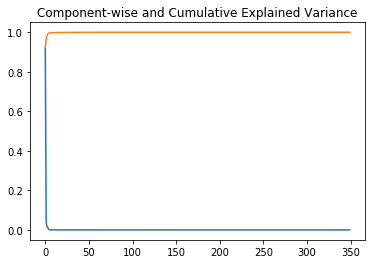

In [45]:
plt.plot(range(350), pca_A.explained_variance_ratio_)
plt.plot(range(350), np.cumsum(pca_A.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

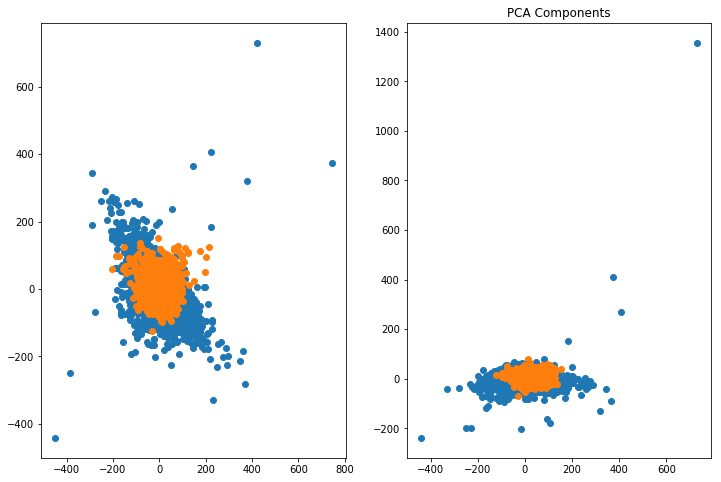

In [314]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 8))
# plt.figure(figsize=(12,8))

plt.title('PCA Components')

comp1 = 0
comp2 = 1

# axarr[0].scatter(pca_result_B[:,comp1], pca_result_B[:,comp2])
# axarr[0].scatter(pca_result_A[:,comp1], pca_result_A[:,comp2])

# axarr[1].scatter(pca_result_B[:,comp1 + 1], pca_result_B[:,comp2 + 1])
# axarr[1].scatter(pca_result_A[:,comp1 + 1], pca_result_A[:,comp2 + 1])

axarr[0].scatter(PCA_dudes['PC2'], PCA_dudes['PC3'])
axarr[0].scatter(pca_data_A_save['PC2'], pca_data_A_save['PC3'])

axarr[1].scatter(PCA_dudes['PC3'], PCA_dudes['PC4'])
axarr[1].scatter(pca_data_A_save['PC3'], pca_data_A_save['PC4'])

# axarr[1].scatter(well_pca_result_A[:,comp1], well_pca_result_A[:,comp2])
# axarr[1].scatter(well_pca_result_B[:,comp1], well_pca_result_B[:,comp2])

# plt.scatter(pca_result_A[:,1], pca_result_A[:,2])
# plt.scatter(pca_result_A[:,2], pca_result_A[:,3])



In [110]:
index_A = bbbc022_train[bbbc022_train['Metadata_pert_id'] == 'DMSO'].index
index_B = bbbc036_train[bbbc036_train['Metadata_pert_id'] == 'DMSO'].index

df_pca_result_A = pd.DataFrame(data = pca_result_A, index=index_A)
df_pca_result_B = pd.DataFrame(data = pca_result_B, index=index_B)

In [297]:
# concatenating Control metaData with PCA compentents

meta_022 = set([f for f in bbbc022_train.columns if f.startswith("Metadata")])
meta_036 = set([f for f in bbbc036_train.columns if f.startswith("Metadata")])

meta_022_s = bbbc022_train[list(meta_022)]
meta_022_s = meta_022_s[meta_022_s['Metadata_pert_id'] == 'DMSO']

meta_036_s = bbbc036_train[list(meta_036)]
meta_036_s = meta_036_s[meta_036_s['Metadata_pert_id'] == 'DMSO']


# final
pca_data_A = pd.concat([meta_022_s, df_pca_result_A], axis=1)
pca_data_B = pd.concat([meta_036_s, df_pca_result_B], axis=1)




In [311]:
pca_data_A_save['PC0']

1        297.167563
2        315.035487
8        -40.950490
9       -327.472426
15       754.370212
16       936.497668
18        41.122168
19       364.603644
22       394.803215
23       128.546169
25       617.976063
26       302.435041
29      1493.456706
30      1126.681641
34       -12.157884
35       392.324500
37       239.796321
38       183.640063
39       813.985712
40       781.936028
41       200.401834
42       128.291511
43        10.999223
44       181.270336
46       974.341303
47       298.413007
50        27.993495
51      -173.465321
52       655.157483
53       739.750824
           ...     
6294    -357.549483
6295    -371.934930
6302    -359.533255
6303    -620.258950
6318    -446.564043
6319    -372.143967
6327    -307.482972
6328    -405.973412
6334    -914.137785
6335    -978.519148
6342     -16.809786
6343    -362.936218
6350    -655.627390
6351    -362.327709
6358    -288.377375
6359    -562.164221
6365    -194.377212
6366    -395.845938
6374    -616.944905


In [280]:
print(len(pca_data_A.columns.values))
print(len(pca_data_B.columns.values))

370
368


In [299]:
pca_data_A.columns.values[0:21]

array(['Metadata_broad_sample_type', 'Metadata_exp', 'Metadata_Well',
       'Metadata_smiles', 'Metadata_Assay_Plate_Barcode',
       'Metadata_pert_mfc_id', 'Metadata_pert_well', 'Metadata_solvent',
       'Metadata_source_name', 'Metadata_Plate', 'Metadata_well_position',
       'Metadata_broad_sample', 'Metadata_pert_vehicle',
       'Metadata_mmoles_per_liter', 'Metadata_cell_id',
       'Metadata_pert_type', 'Metadata_pert_id', 'Metadata_compound_name',
       'Metadata_Plate_Map_Name', 'Metadata_pert_id_vendor', 0],
      dtype=object)

In [301]:
# renaming PC's

x = list(pca_data_A.columns.values[0:20])
for i in range(0,len(pca_data_A.columns.values[21:]) + 1):
    x.append('PC' + str(i))
pca_data_A.columns = x

In [308]:
pca_data_A_save = pca_data_A

In [276]:
pca_data_A['PC1']

1        297.167563
2        315.035487
8        -40.950490
9       -327.472426
15       754.370212
16       936.497668
18        41.122168
19       364.603644
22       394.803215
23       128.546169
25       617.976063
26       302.435041
29      1493.456706
30      1126.681641
34       -12.157884
35       392.324500
37       239.796321
38       183.640063
39       813.985712
40       781.936028
41       200.401834
42       128.291511
43        10.999223
44       181.270336
46       974.341303
47       298.413007
50        27.993495
51      -173.465321
52       655.157483
53       739.750824
           ...     
6294    -357.549483
6295    -371.934930
6302    -359.533255
6303    -620.258950
6318    -446.564043
6319    -372.143967
6327    -307.482972
6328    -405.973412
6334    -914.137785
6335    -978.519148
6342     -16.809786
6343    -362.936218
6350    -655.627390
6351    -362.327709
6358    -288.377375
6359    -562.164221
6365    -194.377212
6366    -395.845938
6374    -616.944905


In [264]:
x1 = list(pca_data_B.columns.values[0:18])
for j in range(0,len(pca_data_B.columns.values[19:]) + 1):
    x1.append('PC' + str(j))
pca_data_B.columns = x1

In [248]:
bbbc036_train["Metadata_Plate_Map_Name"].unique()

array(['H-BIOA-004-3', 'H-BIOA-007-3', 'H-BIOA-001-3', 'H-BIOA-002-3',
       'H-BIOA-003-3', 'H-BIOA-005-3', 'H-BIOA-006-3'], dtype=object)

In [270]:
# PCA_dudes = pca_data_B[pca_data_B['PC0'] < -3000]['Metadata_Plate'].unique()
PCA_dudes = pca_data_B[pca_data_B['PC0'] > -3000]

In [269]:
PCA_dudes.shape

(64, 368)

In [254]:
bbbc036_train_filt = bbbc036_train[bbbc036_train['Metadata_Plate'] != 25962]

In [255]:
print(len(bbbc036_train_filt['Metadata_pert_id'].unique()))
print(len(bbbc036_train['Metadata_pert_id'].unique()))

1964
1964


In [260]:
bbbc036_train_filt.columns.values

array(['Metadata_Plate', 'Metadata_Well', 'Metadata_Assay_Plate_Barcode',
       ..., 'Nuclei_Texture_Variance_RNA_3_0',
       'Nuclei_Texture_Variance_RNA_5_0', 'Metadata_exp'], dtype=object)

In [225]:
# Find common PCA feature set

PCA_features_022 = set([f for f in pca_data_A.columns if f.startswith("PC")])
PCA_features_036 = set([f for f in pca_data_B.columns if f.startswith("PC")])

common_PCA_features = list(PCA_features_022.intersection(PCA_features_036))
print("Number of common features:", len(common_PCA_features))

Number of common features: 350


In [121]:
# Apply transform to calculated PCA space for e.g. test dataset

dude = pca.transform(normalized_022[common_features])

# 3. Load test sets and apply learned model

The test data is not used for training, but needs to be transformed using the same model.

In [317]:
# Load test data

bbbc022_test = cytodata.load_dataset("BBBC022", "Test", FEATURES)
bbbc036_test = cytodata.load_dataset("BBBC036", "Test", FEATURES)

print("Test wells: BBBC022={}, BBBC036={}".format(bbbc022_test.shape[0], bbbc036_test.shape[0]))

1it [00:04,  4.85s/it]
1it [00:10, 10.76s/it]


Test wells: BBBC022=1120, BBBC036=2177


In [147]:
# Apply normalization model

normalized_022_test = model.transform(bbbc022_test)
normalized_036_test = model.transform(bbbc036_test)

In [9]:
# Merge training and test sets

normalized_022 = pd.concat([normalized_022, normalized_022_test])
normalized_036 = pd.concat([normalized_036, normalized_036_test])

In [150]:
# normalized_022_test = well_model.transform(bbbc022_test)
well_normalized_022_test = well_model.transform(bbbc022_test)
well_normalized_036_test = well_model.transform(bbbc036_test)


In [151]:
well_pca_result_A_test = pca_A.transform(well_normalized_022_test[common_features])
well_pca_result_B_test = pca_B.transform(well_normalized_036_test[common_features])

In [178]:
index_A_test = bbbc022_test['Metadata_pert_id']
index_B_test = bbbc036_test['Metadata_pert_id']

df_well_pca_result_A_test = pd.DataFrame(data = well_pca_result_A_test, index=index_A_test)
df_well_pca_result_B_test = pd.DataFrame(data = well_pca_result_B_test, index=index_B_test)

In [ ]:
df_well_pca_result_B

In [181]:
# Merge training and test sets

normalized_022_all = pd.concat([df_well_pca_result_A, df_well_pca_result_A_test])
normalized_036_all = pd.concat([df_well_pca_result_B, df_well_pca_result_B_test])

# 4. Aggregate profiles
All the processes above work at with well-level data, also known as replicate-level data. Now we need to aggregate and transform well-level data into treatment-level profiles. In this example, we use the mean profiling technique.

In [195]:
# Compute mean profile of treatments (accross replicates)

aggr_normalized_022_all = normalized_022.groupby(["Metadata_pert_id"]).mean()


aggr_normalized_036_all = normalized_036.groupby(["Metadata_pert_id"]).mean()

In [204]:
aggr_normalized_022_all = aggr_normalized_022_all.drop('DMSO')
aggr_normalized_036_all = aggr_normalized_036_all.drop('DMSO')

In [206]:
aggr_normalized_036_all.shape

(2238, 1783)

In [197]:
print("Shape of treatment-level data", aggr_normalized_022_all.shape, aggr_normalized_036_all.shape)

Shape of treatment-level data (1543, 1783) (2239, 1783)


# 5. Compute connectivity matrix
With treatment-level profiles, proceed to match treatments from one database to the other. In this example we match treatments using Pearson Correlation similarity function.

**Important**: the values of the connectivity matrix are assumed to be similarity values (higher scores mean higher connectivity) as opposed to distance values (higher scores mean longer distances and low connectivity).

In [211]:
# Similarity matrix using Pearson Correlation

corr_matrix = np.corrcoef(x=aggr_normalized_022_all, y=aggr_normalized_036_all)
corr_matrix = corr_matrix[0:aggr_normalized_022_all.shape[0], aggr_normalized_022_all.shape[0]:]

In [212]:
# Statistics of the connectivity matrix

print("Connectivity matrix shape:", corr_matrix.shape)
print("Max: {}, Min: {}, Mean: {}, Median: {}".format(np.max(corr_matrix), np.min(corr_matrix), np.mean(corr_matrix), np.median(corr_matrix)))

Connectivity matrix shape: (1542, 2238)
Max: 0.8083751459419947, Min: -0.8030198940359726, Mean: 0.03633109819044813, Median: 0.050162500327383966


In [ ]:
# Similarity matrix using Pearson Correlation

corr_matrix = np.corrcoef(x=aggregated_022[common_features], y=aggregated_036[common_features])
corr_matrix = corr_matrix[0:aggregated_022.shape[0], aggregated_022.shape[0]:]

In [210]:
# Statistics of the connectivity matrix

print("Connectivity matrix shape:", corr_matrix.shape)
print("Max: {}, Min: {}, Mean: {}, Median: {}".format(np.max(corr_matrix), np.min(corr_matrix), np.mean(corr_matrix), np.median(corr_matrix)))

Connectivity matrix shape: (1542, 2238)
Max: 0.8083751459419947, Min: -0.8030198940359726, Mean: 0.03633109819044813, Median: 0.050162500327383966


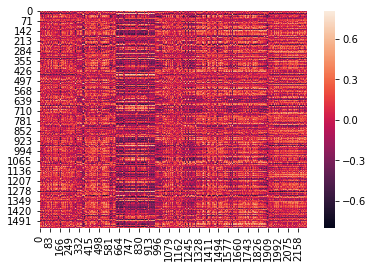

In [213]:
# Visualization of the connectivity matrix

sb.heatmap(corr_matrix)

# 6. Create submission file

Finally, save the connectivity matrix using treatment-level profiles, with columns and rows labeled with the ID of treatments. 

In [214]:
submission = pd.DataFrame(
    data=corr_matrix, 
    index=aggr_normalized_022_all.index, 
    columns=aggr_normalized_036_all.index)

submission = submission.reset_index()

In [215]:
SUBMISSION_NAME = "cytodata-baseline-day2"
submission.to_csv(SUBMISSION_NAME + ".csv", index=False)